# Control on Gym Pendulum

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathisfederico/controlgym/blob/master/notebooks/pendulum.ipynb)

# Setup

## Dependencies

In [1]:
try:
    import controlgym
except ImportError:
    !pip install git+https://github.com/MathisFederico/ControlGym.git

## Rendering

In [2]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate
!apt-get install -y ffmpeg

'apt-get' is not recognized as an internal or external command,
operable program or batch file.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import sys
from controlgym.video import show_video, record_video

if not sys.platform.startswith('win32'):
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

# Pendulum

## Start at equilibrium

### Random Agent

In [4]:
from gym.wrappers.time_limit import TimeLimit
from controlgym.envs.pendulum import UpPendulumEnv

upenv = UpPendulumEnv(g=9.81)
upenv = TimeLimit(upenv, max_episode_steps=200)

In [5]:
from controlgym.agents import RandomAgent
random_agent = RandomAgent(upenv.action_space)
record_video(upenv, random_agent, steptime=upenv.dt)
show_video()

### LQR Control

In [6]:
from controlgym.envs.pendulum import get_pendulum_linear_model, get_pendulum_linear_lqr_gain

upmodel = get_pendulum_linear_model(upenv, 1)
print(upmodel)

K = get_pendulum_linear_lqr_gain(upmodel)
print("Computed gain matrix:", K)

<LinearIOSystem>: sys[2]$sampled
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']
States (2): ['x[0]', 'x[1]']

A = [[1.01228758 0.05020463]
     [0.49250738 1.01228758]]

B = [[-0.00375767]
     [-0.15061388]]

C = [[1. 0.]
     [0. 1.]]

D = [[0.]
     [0.]]

dt = 0.05

Computed gain matrix: [[-17.90204232  -5.67967853]]


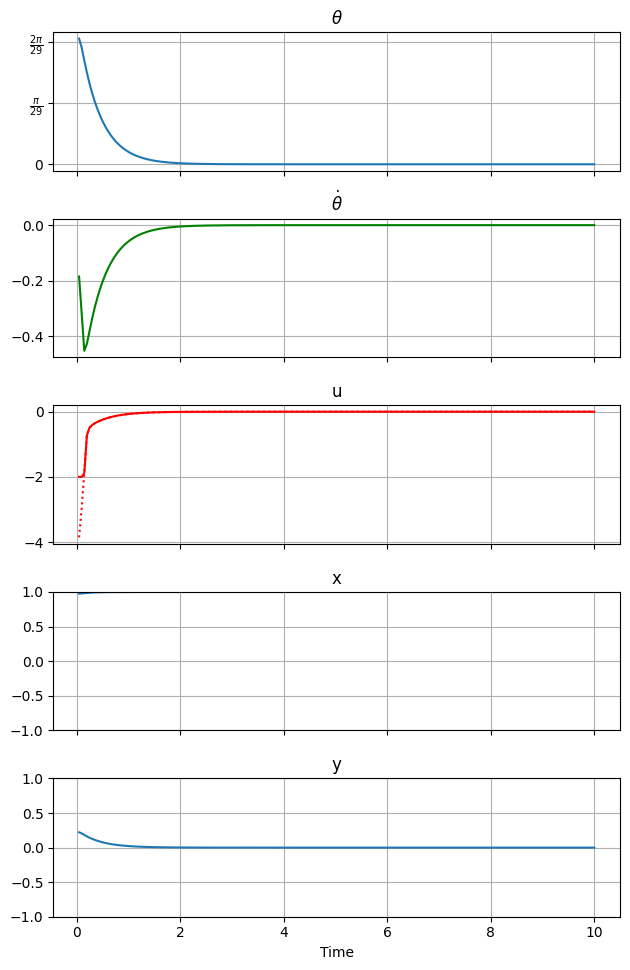

In [7]:
import numpy as np
from controlgym.envs.pendulum import plot_pendulum_history, thetas_from_obs, pendulum_obs_to_state
from controlgym.agents.control import LinearControlAgent

control_agent = LinearControlAgent(K, obs_to_state=pendulum_obs_to_state)
observations, actions, times = record_video(upenv, control_agent, steptime=upenv.dt)

thetas, thetadots = thetas_from_obs(observations)
plot_pendulum_history(times, actions, thetas, thetadots, max_torque=upenv.max_torque)
show_video()

## Start at bottom position

In [8]:
from gym.wrappers.time_limit import TimeLimit
from controlgym.envs.pendulum import DownPendulumEnv


downenv = DownPendulumEnv(g=9.81)
downenv = TimeLimit(downenv, max_episode_steps=200)

### Random agent

In [9]:
random_agent = RandomAgent(downenv.action_space)
record_video(downenv, random_agent, steptime=downenv.dt)
show_video()

### LQR Control

In [10]:
model = get_pendulum_linear_model(downenv, 1)
K = get_pendulum_linear_lqr_gain(model)
control_agent = LinearControlAgent(K, obs_to_state=pendulum_obs_to_state)
observations, actions, times = record_video(downenv, control_agent, steptime=downenv.dt)

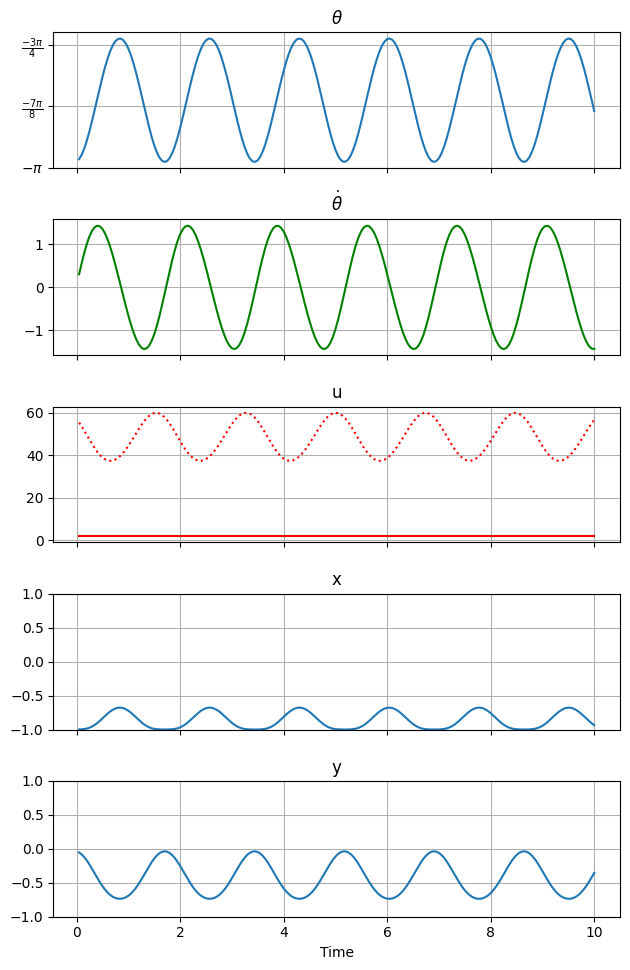

In [11]:
thetas, thetadots = thetas_from_obs(observations)
plot_pendulum_history(times, actions, thetas, thetadots, max_torque=downenv.max_torque)
show_video()

### HEBG + LQR Control

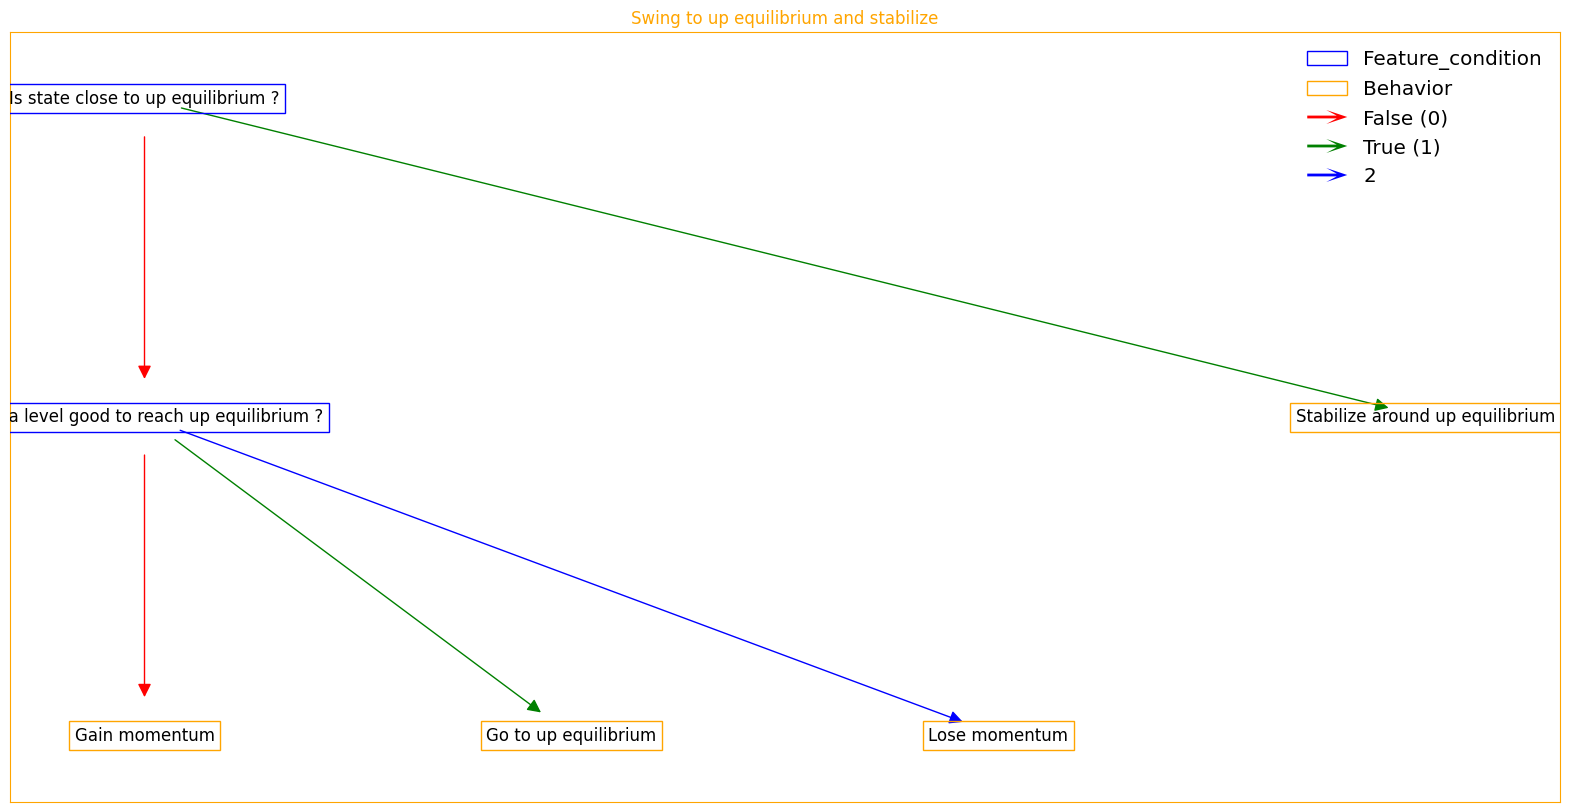

In [12]:
from hebg import HEBGraph, FeatureCondition, Behavior

call_history = []

class IsCloseToUpEquilibrium(FeatureCondition):
   def __init__(self) -> None:
      super().__init__(name="Is state close to up equilibrium ?")
   def __call__(self, observation):
      close_in_x = np.abs(observation[0]-1) < np.sqrt(2)/2
      close_in_y = np.abs(observation[1]) < 1/2
      not_too_fast = np.abs(observation[2]) < 3
      return close_in_x and close_in_y and not_too_fast


class StabilizeAroundUpEquilibrium(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Stabilize around up equilibrium")
        model = get_pendulum_linear_model(downenv, 1)
        K = get_pendulum_linear_lqr_gain(model)
        self.control_agent = LinearControlAgent(K, obs_to_state=pendulum_obs_to_state)

    def __call__(self, observation, *args, **kwargs):
        call_history.append(self.name)
        return self.control_agent.act(observation)


class InertiaLevel(FeatureCondition):
    def __init__(self) -> None:
        super().__init__(name="Inertia level good to reach up equilibrium ?")
        self.g = downenv.g

    def __call__(self, observation):
        z = observation[0] + 1
        inertia = np.power(observation[2], 2)/2 + self.g*z
        if inertia < 2 * self.g:
            return 0 # Too slow
        if inertia > 3 * self.g:
            return 2 # Too fast
        return 1

class GainMomentum(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Gain momentum")
        self.max_torque = downenv.max_torque

    def __call__(self, observation, *args, **kwargs):
        call_history.append(self.name)
        return np.array([self.max_torque * np.sign(observation[2])])

class LoseMomentum(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Lose momentum")
        self.max_torque = downenv.max_torque

    def __call__(self, observation, *args, **kwargs):
        call_history.append(self.name)
        return np.array([- self.max_torque * np.sign(observation[2])])

class GoToUpEquilibrium(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Go to up equilibrium")
        model = get_pendulum_linear_model(downenv, -1)
        K = get_pendulum_linear_lqr_gain(model)
        self.control_agent = LinearControlAgent(K, obs_to_state=pendulum_obs_to_state)

    def __call__(self, observation, *args, **kwargs):
        call_history.append(self.name)
        return self.control_agent.act(observation)

class SwingToUpEquilibrium(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Swing to up equilibrium")
    def build_graph(self) -> HEBGraph:
        graph = HEBGraph(self)
        inertia_level = InertiaLevel()
        graph.add_edge(inertia_level, GainMomentum(), index=0)
        graph.add_edge(inertia_level, LoseMomentum(), index=2)
        graph.add_edge(inertia_level, GoToUpEquilibrium(), index=1)
        return graph

class SwingUpAndStabilize(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Swing to up equilibrium and stabilize")
    def build_graph(self) -> HEBGraph:
        graph = HEBGraph(self)
        is_close_to_up_eq = IsCloseToUpEquilibrium()
        graph.add_edge(is_close_to_up_eq, SwingToUpEquilibrium(), index=int(False))
        graph.add_edge(is_close_to_up_eq, StabilizeAroundUpEquilibrium(), index=int(True))
        return graph

swing_up_behavior = SwingUpAndStabilize()

# Obtain networkx graph
graph = swing_up_behavior.graph

# Draw graph using matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=[20, 10], dpi=100)
graph.unrolled_graph.draw(ax)
plt.show()

In [13]:
from controlgym.agents import HEBGAgent

swing_up_hebg_agent = HEBGAgent(swing_up_behavior)
call_history = []
observations, actions, times = record_video(downenv, swing_up_hebg_agent, steptime=downenv.dt)

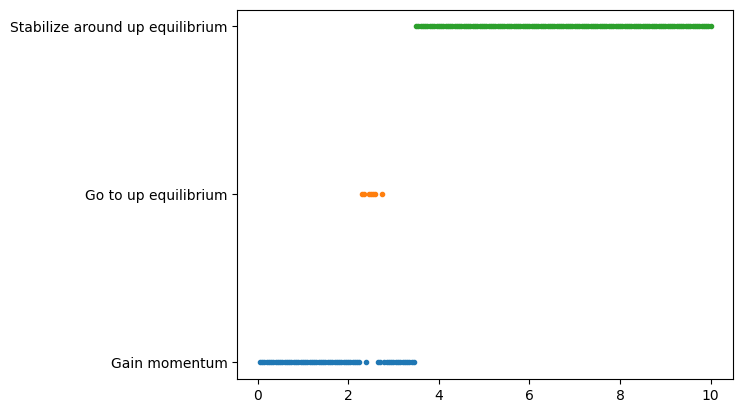

In [14]:
from controlgym.plotting import plot_hebg_call_history

plot_hebg_call_history(times, call_history)

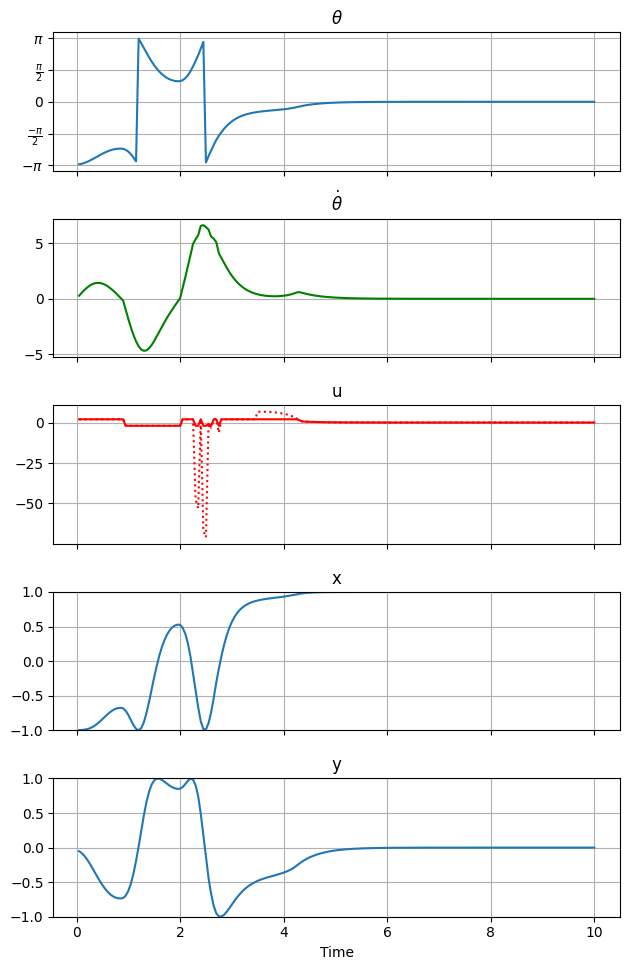

In [15]:
thetas, thetadots = thetas_from_obs(observations)
plot_pendulum_history(times, actions, thetas, thetadots, max_torque=downenv.max_torque)
show_video()

## Start at completely random position & speed

### Random Agent

In [16]:
from controlgym.envs.pendulum import RandomPendulumEnv

randenv = RandomPendulumEnv(g=9.81)
randenv = TimeLimit(randenv, max_episode_steps=200)

In [17]:
random_agent = RandomAgent(randenv.action_space)
record_video(randenv, random_agent, steptime=randenv.dt)
show_video()

### HEBG + LQR Control

In [39]:
call_history = []
observations, actions, times = record_video(randenv, swing_up_hebg_agent, steptime=randenv.dt)

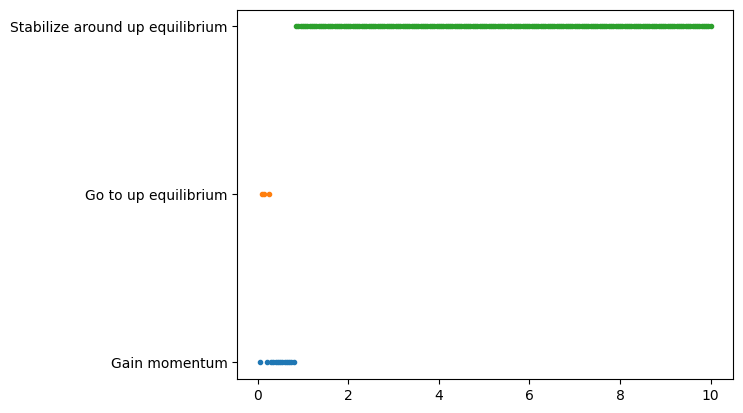

In [40]:
plot_hebg_call_history(times, call_history)

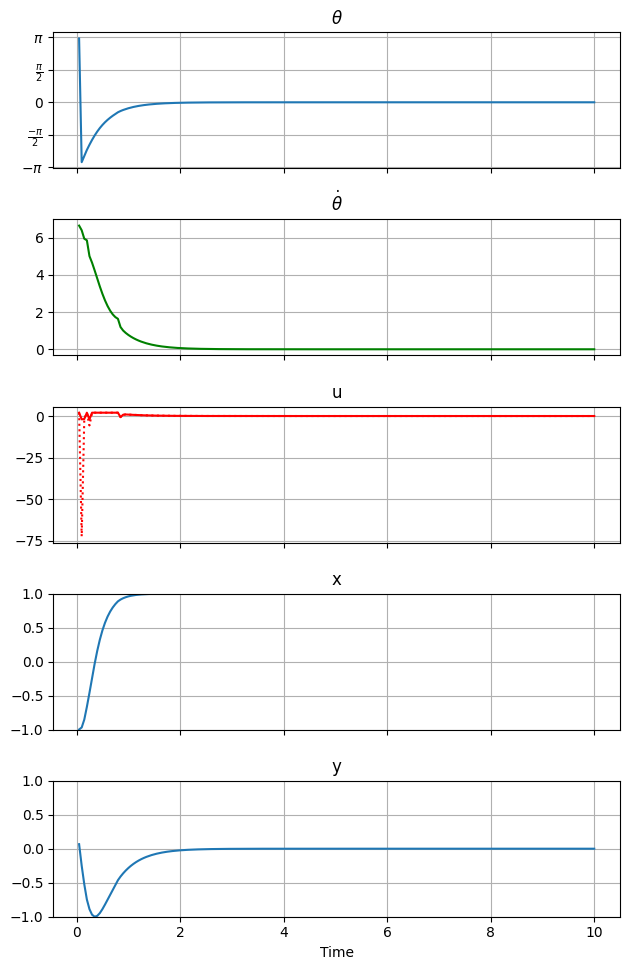

In [41]:
thetas, thetadots = thetas_from_obs(observations)
plot_pendulum_history(times, actions, thetas, thetadots, max_torque=downenv.max_torque)
show_video()